In [268]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import praw, requests
import matplotlib.pyplot as plt
import time
import re
%matplotlib inline

In [2]:
reddit = praw.Reddit(client_id = 'QPLNKgwv94Zx2A',
                     client_secret = 'aqwyGK3EAWC9-IeSN7tR6GhNZCc',
                     password ='bulldogs11',
                     user_agent = 'chromium:CommentPuller:v0.1 (by -jaylew-)',
                     username ='-jaylew-',
                     ) ##initialize a reddit instance, log in using my info

In [3]:
print(reddit.user.me()) ##check that I logged in

-jaylew-


In [32]:
#Make the initial empty list of titles, define the subreddit to investigate
titles = []
scores = []
subreddit = reddit.subreddit('natureisfuckinglit')

#Go through all the top 'limit' submissions, filter out non-alphabetical characters, make them lowercase
for submission in subreddit.top('all', limit=1000):
    scores.append(submission.score)
    title = submission.title.split()
    title = ' '.join(filter(str.isalpha, title)).lower()
    #Append the processed title to the list of titles
    titles.append(title)

In [36]:
#Create initial dataframe to be worked with
natureLitDf = pd.DataFrame()
natureLitDf['Title'] = titles
natureLitDf['Score'] = scores

In [55]:
#Create a lemmatized version of the titles
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

In [56]:
wnLem = WordNetLemmatizer()

natureLitDf['Lemmatized Title'] = natureLitDf['Title'].apply(lambda txt: ' '.join([wnLem.lemmatize(x) for x in txt.split()])   ) 

In [64]:
#Get a list of animal names to be used as a basis for whether a title contains an animal name

In [66]:
from wikitables import import_tables

In [67]:
tables = import_tables('List of animal names')

In [183]:
animals = []
for row in tables[1].rows:
    #Get the animal name from the row of the table
    animal = ('{Animal}'.format(**row).split()[0].lower())
    #Remove any punctuations from the row entry
    animal = ''.join(filter(str.isalpha, animal))
    animals.append(animal)

#Do this to remove some odd 'animal' results
problems = ['a', 'water', 'i', 'sea', 'giant', 'sand']
animals = [x for x in animals if x not in problems]
#Adding in new animals I saw were not included but were in titles
extras = ['rhino', 'cuttlefish', 'moth', 'chameleon', 'woodpecker', 'peacock', 'osprey', 'urchin', 'pangolin', 'swordfish', 'tulip', 'bumblebee', 'clam', 'macaw', 'axolotl', 'starfish', 'fungus', 'puma', 'beetle', 'viper', 'dragon', 'sugar glider', 'scorpion', 'mantis', 'python', 'shrimp', 'coral', 'grizzly', 'stallion', 'iguana' ]
animals = animals+extras

In [205]:
#Create the column showing only the animals in the title
natureLitDf['Animals in Title'] = natureLitDf['Lemmatized Title'].apply(lambda txt: ' '.join([word for word in txt.split() if word in animals]))

In [207]:
from sklearn.feature_extraction.text import CountVectorizer

In [214]:
vectorizer = CountVectorizer()
animalsX = vectorizer.fit_transform(natureLitDf['Animals in Title'])

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


In [215]:
animalCountDf = pd.DataFrame(animalsX.A, columns=vectorizer.get_feature_names())
animalCountDf.head(5)

/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


,alligator,ant,antelope,armadillo,axolotl,baboon,badger,bat,bear,bee,...,turtle,urchin,viper,walrus,wasp,whale,wolf,woodpecker,yak,zebra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [319]:
group = animalCountDf.sum().sort_values(ascending=False)
group = group[group>2]
names = list(group.keys())
counts = list(group.values)

In [320]:
import seaborn as sns

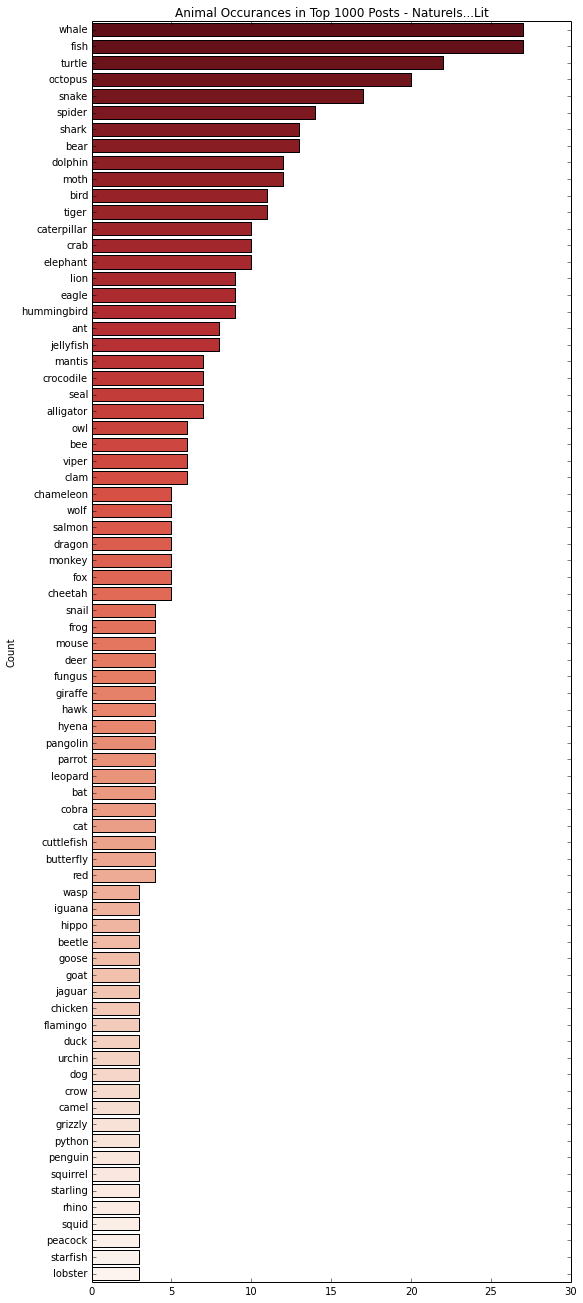

In [394]:
plt.figure(figsize=(8,18))
sns.barplot(y=names, x=counts, palette=('Reds_r'))
plt.tight_layout()
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation=0);
plt.title('Animal Occurances in Top 1000 Posts - NatureIs...Lit')

In [345]:
#Lets see which animals average higher scoring posts.
titlesAndAnimalsDf = natureLitDf.join(animalCountDf)
titlesAndAnimalsDf.head()

,Title,Score,Lemmatized Title,Animals in Title,alligator,ant,antelope,armadillo,axolotl,baboon,...,turtle,urchin,viper,walrus,wasp,whale,wolf,woodpecker,yak,zebra
0,morning commute in earlier,93207,morning commute in earlier,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,curious tuna crabs inspecting a diver friend,63738,curious tuna crab inspecting a diver friend,crab,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cows trying to scare canada goose,62891,cow trying to scare canada goose,goose,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,thor is alive,61179,thor is alive,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,how alligators survive when the water freezes,57423,how alligator survive when the water freeze,alligator,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [363]:
#Groupby each animal who appears more than twice, then take the mean of their scores.
meanScores = []
for animal in names:
    average = titlesAndAnimalsDf.groupby(by=animal).mean()['Score'].mean()
    average = round(average, 0)
    meanScores.append(average)

In [373]:
#Make a new sortable dataframe for the mean scores and animal names
animalsAndScores = pd.DataFrame()
animalsAndScores['Animals'] = names
animalsAndScores['Occurances'] = counts
animalsAndScores['Mean Scores'] = meanScores
animalsAndScores.sort_values(by='Mean Scores', ascending=False, inplace=True)
animalsAndScores.head()

,Animals,Occurances,Mean Scores
37,mouse,4,34200.0
56,goose,3,26824.0
52,wasp,3,26470.0
63,dog,3,25450.0
57,goat,3,25201.0


In [424]:
#Make a palette based on the number of occurances for the animal
occuranceColours = animalsAndScores['Occurances'].unique()
occurancePalette= sns.color_palette('hls', 16)
occuranceDict = dict(zip(occuranceColours, occurancePalette))
animalsAndScores['Colour'] = animalsAndScores['Occurances'].apply(lambda num: occuranceDict[num])

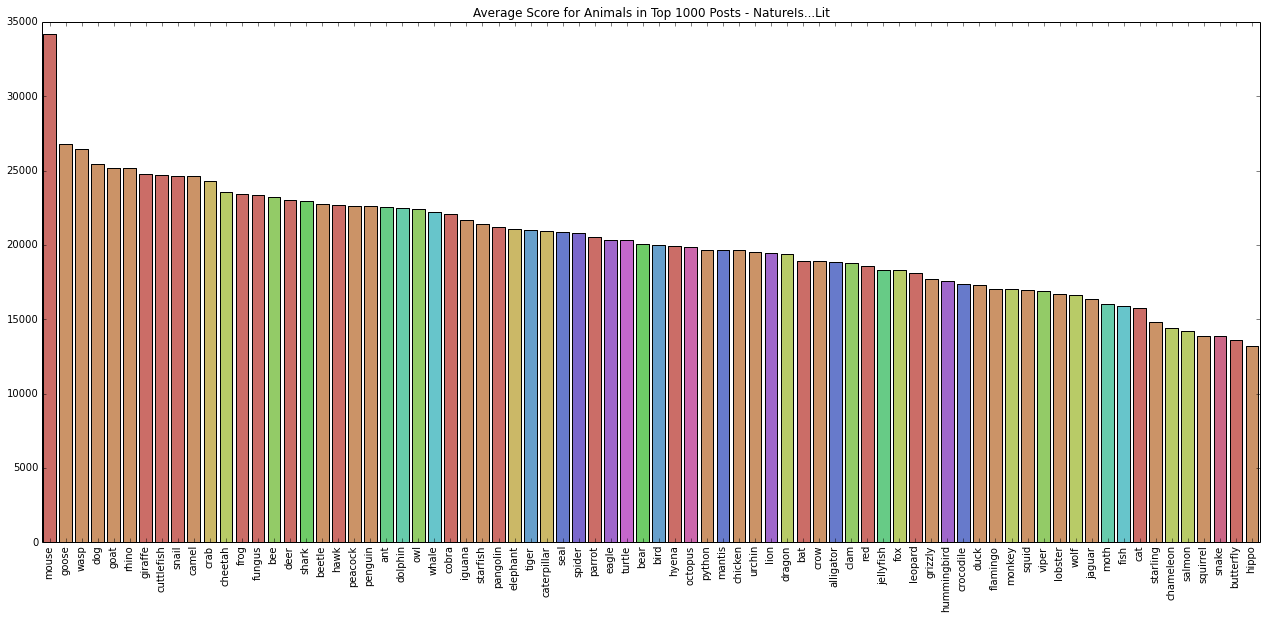

In [425]:
#Plot the new data
plt.figure(figsize=(18,8))
sns.barplot(x='Animals', y='Mean Scores', palette=animalsAndScores['Colour'], data=animalsAndScores)
plt.tight_layout()
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=90);
plt.title('Average Score for Animals in Top 1000 Posts - NatureIs...Lit')